## data leakage 를 막기 위한 sklearn pipeline tutorial

**<u>reference:</u>** https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976

### 1. 데이터셋 구성하기

In [1]:
"""
https://github.com/suvoooo/Machine_Learning/blob/master/winequality-red.csv
위 경로에서 csv 파일 가져오기
"""

import requests
from bs4 import BeautifulSoup as bs

# 크롤링
url = 'https://github.com/suvoooo/Machine_Learning/blob/master/winequality-red.csv'
req = requests.get(url)
html = req.text
soup = bs(html, 'html.parser').select('tr > td.blob-code')

csv = ""
for s in soup:
    csv += s.text
    csv += '\n'

# csv 파일로 저장
with open('조윤기_winequality-red.csv', 'w') as f:
    f.write(csv)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('조윤기_winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


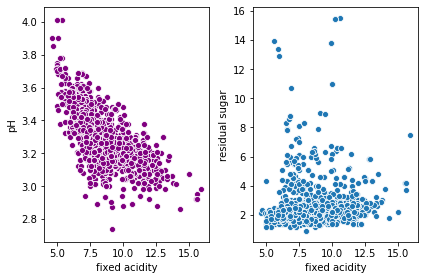

In [3]:
# check corr with visualization

fig, ax = plt.subplots(ncols=2)

sns.scatterplot(data=df, x='fixed acidity', y='pH', ax=ax[0], color='purple')
sns.scatterplot(data=df, x='fixed acidity', y='residual sugar', ax=ax[1])

fig.tight_layout()

pH 와 acidity 는 강한 음의 상관관계가 있는것으로 보입니다.

In [4]:
# dataset 구성
X = df.drop(['quality'], axis=1)
y = df['quality']

### 2. pipeline 사용하기

In [5]:
# fitting 할 스케일러, 모델
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

steps = [('scaler', StandardScaler()), ('RFC', RandomForestClassifier())]
# 위 파이프라인 steps 에서, 가장 마지막 step은 반드시 'estimator'가 되어야 합니다.

In [6]:
from sklearn.pipeline import Pipeline  # Pipeline class

pipeline = Pipeline(steps)  # 파이프라인 만들기 (StandardScaler -> SVC)

In [7]:
from sklearn.model_selection import train_test_split
"""
stratify?
stratify 로 지정된 데이터의 비율을 유지한다.
예를 들어 label set이 25% 의 0, 75%의 1을 가진 binary set이면 
이 비율을 유지한 채로 분할한다.
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# params key 값은 'steps' 에서 지정한 모델의 '이름__' 로 시작합니다.
params = {'RFC__max_depth': [10, 20, None],
          'RFC__n_estimators': [10, 100, 500, 1000],
          'RFC__random_state': [42]}

In [9]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipeline, param_grid=params, cv=5)

In [10]:
grid.fit(X_train, y_train)
print(f'score {grid.score(X_test, y_test):3.2f}')
print(grid.best_params_)

score 0.68
{'RFC__max_depth': 20, 'RFC__n_estimators': 1000, 'RFC__random_state': 42}


#### 2-1. pipeline 없이 진행하기

In [11]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

params = {'max_depth': [10, 20, None],
          'n_estimators': [10, 100, 500, 1000],
          'random_state': [42]}

grid = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5)
grid.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)
print(f'score: {grid.score(X_test, y_test):3.2f}')
print(grid.best_params_)

score: 0.42
{'max_depth': 20, 'n_estimators': 1000, 'random_state': 42}
